In [7]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [8]:
# Load data (assuming you have a customer churn dataset)

train=pd.read_csv('dataset/churn/customer_churn_dataset-training-master.csv')
test=pd.read_csv('dataset/churn/customer_churn_dataset-testing-master.csv')

df = pd.concat([train,test],axis=0) #Combined both Train and Test Data set

# Replace spaces with underscores in all column names
df.columns = df.columns.str.replace(' ', '_')

list(df.loc[df['Churn'].isin([0])])[:10]

list(df.loc[df['Churn'].isin([0])])[0]


'CustomerID'

In [10]:

# Display first few rows of the dataset
def know_data(df):
    print("\n\n\n<<HEAD>>\n")
    print(df.head(10))
    print("\n\n\n<<TAIL>>\n")
    print(df.tail(10))
    print("\n\n\n<<DESCRIBE>>\n")
    print(df.describe())
    print("\n\n\n<<INFO>>\n")
    print(df.info())


In [12]:
num_cols = ['CustomerID','Age','Tenure','Usage_Frequency','Support_Calls','Payment_Delay','Total_Spend','Last_Interaction','Churn']
cat_cols = ['Gender', 'Subscription_Type', 'Contract_Length']

def preprocess(df):
  # Check for missing values
  df.isnull().sum()
  
  # Replace spaces with underscores in all column names
  df.columns = df.columns.str.replace(' ', '_')

  # Handle missing values by imputing (filling) with mean for numerical columns and mode for categorical ones
  imputer = SimpleImputer(strategy='mean')
  for v in num_cols:
    if v != 'CustomerID':
      df[v] = imputer.fit_transform(df[[v]]).astype(int)
    else:
      df[v] = imputer.fit_transform(df[[v]])

  # For categorical variables (e.g., 'gender', 'contract_type'), use mode
  for v in cat_cols:
    df[v].fillna(df[v].mode()[0], inplace=True)

  # # Convert categorical variables to numerical using LabelEncoder (or OneHotEncoder if necessary)
  le = LabelEncoder()
  for v in cat_cols:
    df[v] = le.fit_transform(df[v])

  # # Feature and target variable
  X = df.drop('Churn', axis=1)  # Features
  y = df['Churn']  # Target variable

  # # Scaling features (optional but recommended for some algorithms)
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  return X,y,X_scaled



In [13]:
X,y,X_scaled = preprocess(df)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# know_data(y_train)  # Or just print(y_train) for more details


In [36]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93     44963
           1       0.94      0.95      0.94     56079

    accuracy                           0.94    101042
   macro avg       0.94      0.93      0.93    101042
weighted avg       0.94      0.94      0.94    101042



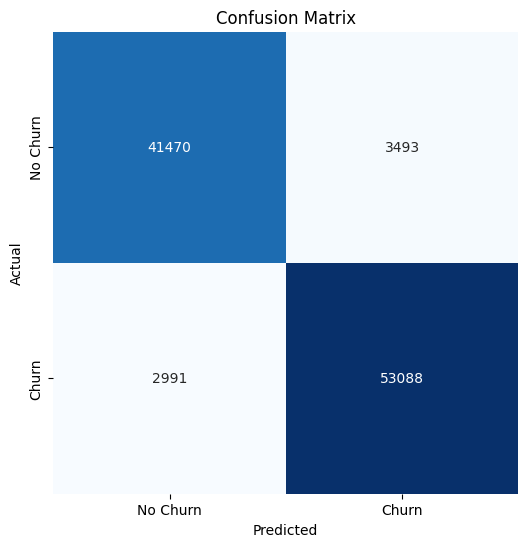

ROC-AUC: 0.9345


In [37]:
# Make predictions
y_pred = rf.predict(X_test)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.4f}")


In [ ]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Best model from grid search
best_rf = grid_search.best_estimator_

# Evaluate best model
y_pred_best = best_rf.predict(X_test)
print("Best Model Classification Report:\n", classification_report(y_test, y_pred_best))


# Save the model
joblib.dump(best_rf, 'model/customer_churn/customer_churn_model.pkl')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93     44963
           1       0.94      0.95      0.94     56079

    accuracy                           0.94    101042
   macro avg       0.94      0.93      0.94    101042
weighted avg       0.94      0.94      0.94    101042



In [14]:

# Load the saved model for future predictions
loaded_model = joblib.load('model/customer_churn/customer_churn_model.pkl')


In [ ]:
# Train the model
loaded_model.fit(X_train, y_train)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93     44963
           1       0.94      0.95      0.94     56079

    accuracy                           0.94    101042
   macro avg       0.94      0.93      0.94    101042
weighted avg       0.94      0.94      0.94    101042



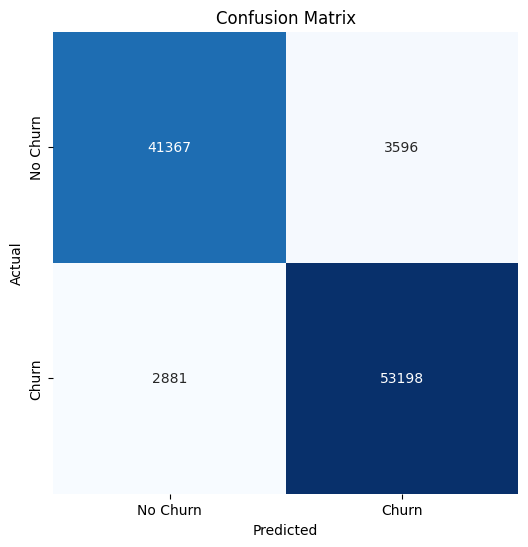

ROC-AUC: 0.9343


In [15]:
# Make predictions
y_pred = loaded_model.predict(X_test)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

In [88]:

# Save the model
joblib.dump(loaded_model, 'model/customer_churn/customer_churn_model.pkl')

['model/customer_churn/customer_churn_model.pkl']

In [16]:

# Predict new customer data
new_customer_data = test  # Example of new customer features (scaled)
X,y,new_customer_data_scaled = preprocess(new_customer_data)
churn_prediction = loaded_model.predict(new_customer_data_scaled)
customer_data = new_customer_data.copy()

print(f"Churn Prediction (1: Churn, 0: No Churn): {churn_prediction}")


Churn Prediction (1: Churn, 0: No Churn): [1 0 0 ... 1 0 1]


In [17]:

#Add the prediction result back to the DataFrame
customer_data['churn_prediction'] = churn_prediction

# Print the prediction
# print(new_customer_data[['CustomerID', 'churn_prediction']])


1. Bar Chart (Churn vs. No Churn)
A simple bar chart can help you visualize the number of churned and non-churned customers.

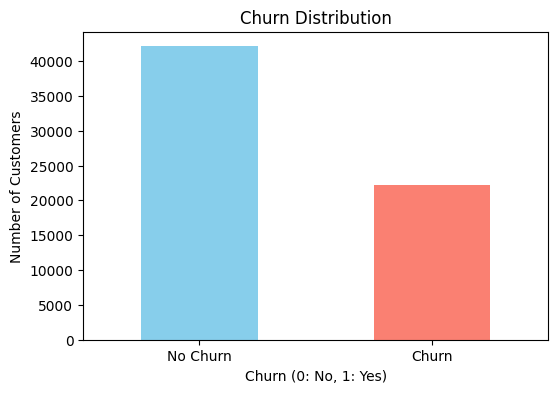

In [18]:

# Plot a bar chart of churn distribution
plt.figure(figsize=(6,4))
customer_data['churn_prediction'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Distribution')
plt.xlabel('Churn (0: No, 1: Yes)')
plt.ylabel('Number of Customers')
plt.xticks([0, 1], ['No Churn', 'Churn'], rotation=0)
plt.show()


2. Scatter Plot (Churn vs. Features)
If you want to visualize how a specific feature (e.g., age, spending) relates to churn, you can create a scatter plot, coloring the points by whether the customer churned.

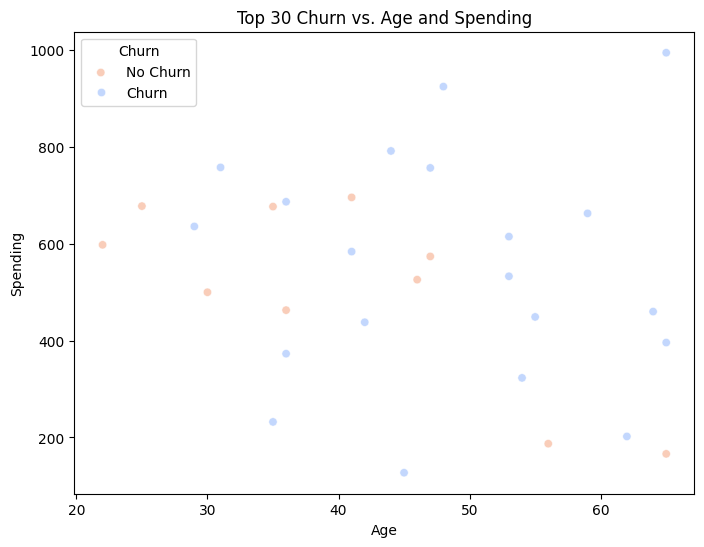

In [19]:
# Example: Churn vs. Age
plt.figure(figsize=(8,6))
sns.scatterplot(x='Age', y='Total_Spend', hue='churn_prediction', data=customer_data[0:30], palette='coolwarm', alpha=0.7)
plt.title('Top 30 Churn vs. Age and Spending')
plt.xlabel('Age')
plt.ylabel('Spending')
plt.legend(title='Churn', labels=['No Churn', 'Churn'])
plt.show()


3. Pie Chart (Proportion of Churn vs. No Churn)
A pie chart is a good way to visualize the proportion of churned and non-churned customers.

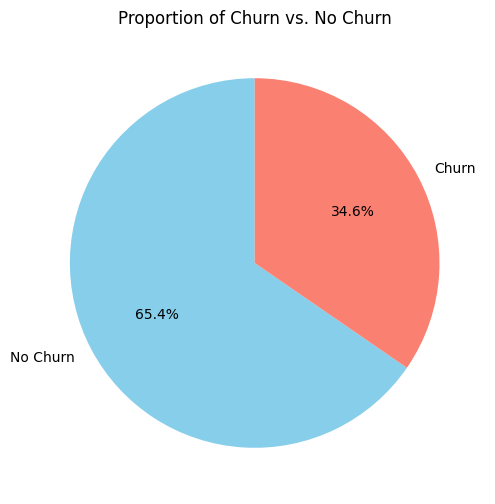

In [20]:
# Plot a pie chart for churn distribution
plt.figure(figsize=(6,6))
customer_data['churn_prediction'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90, labels=['No Churn', 'Churn'])
plt.title('Proportion of Churn vs. No Churn')
plt.ylabel('')  # Hide the y-axis label for clarity
plt.show()


4. Heatmap (Feature Correlation with Churn)
A heatmap can show the correlation between features and churn. If you have multiple numerical features, you can visualize how each feature correlates with churn.

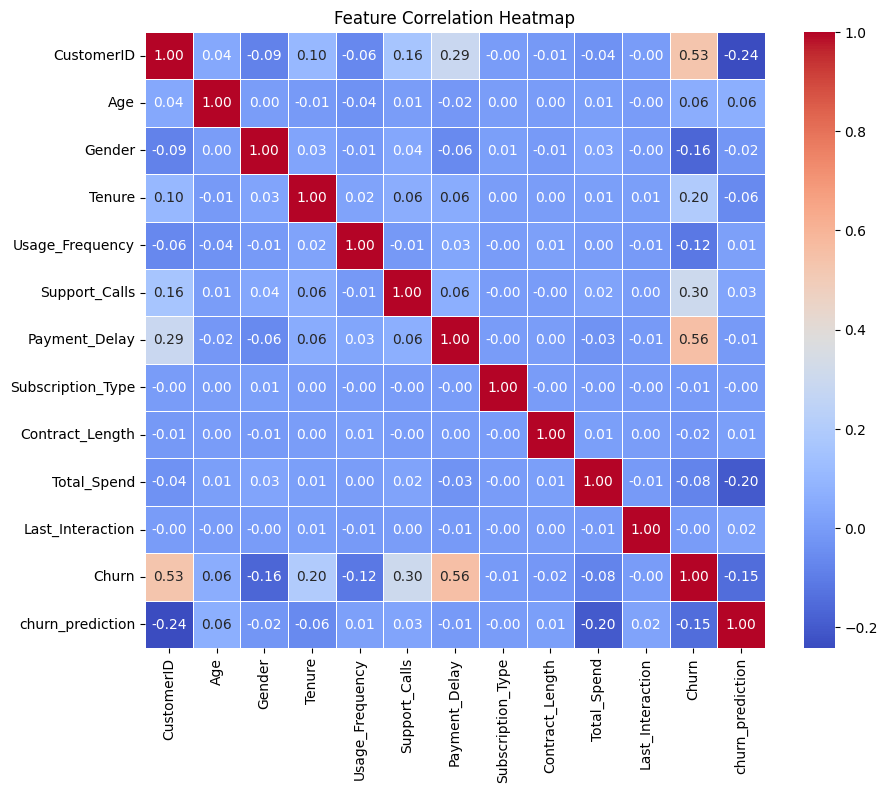

In [109]:

# Compute the correlation matrix
corr_matrix = customer_data.corr()

# Create a heatmap to show correlation between features
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

5. Pairplot (Churn vs Multiple Features)
If you want to visualize the relationships between several features and churn, you can use a pairplot, which creates scatter plots for all feature pairs, colored by churn status.

In [ ]:
# Plot pairplot of selected features
sns.pairplot(customer_data[0:5], hue='churn_prediction', palette='coolwarm', markers=["o", "s"], plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features Colored by Top 5 Churn", y=1.02)
plt.show()


In [ ]:
# Visualize the churn prediction (Bar chart)
plt.figure(figsize=(6,4))
churn_status = customer_data['churn_prediction'].value_counts()
churn_status.plot(kind='bar', color=['salmon', 'skyblue'])

plt.title(f"Churn Prediction for Customer ID: {customer_data['customer_id'][0]}")
plt.xlabel('Churn Status (1: Churn, 0: No Churn)')
plt.ylabel('Number of Predictions')
plt.xticks([0, 1], ['No Churn', 'Churn'], rotation=0)
plt.show()